c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0182 - val_loss: 0.0025
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0165 - val_loss: 0.0027
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0101 - val_loss: 0.0021
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0013
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 9.3420e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - val_loss: 8.2905e-05
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 8.8482e-05
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020 - val_loss: 1.7501e-05
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 2.0555e-05
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 3.4803e-05
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 3.4951e-05
Epoch 12/100
38/38 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
✅ MAE: 0.383, RMSE: 0.560


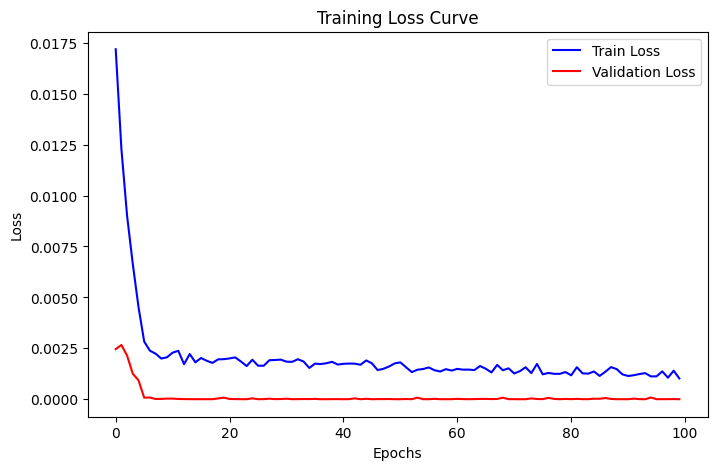

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 🚀 1. Load and Preprocess Data
df = pd.read_csv("preprocessed_book_data.csv")

# Convert publication date to datetime
df["publication_date"] = pd.to_datetime(df["publication_date"], errors='coerce')
df["order_month"] = df["publication_date"].dt.to_period("M")

# Aggregate order count per book
order_counts = df.groupby("book_id").size().reset_index(name="order_count")

# Merge back into the main dataframe
df = df.merge(order_counts, on="book_id", how="left").fillna({'order_count': 0})

# Create Monthly Demand Aggregation
monthly_demand = df.groupby("order_month")["order_count"].sum().reset_index()
monthly_demand["order_month"] = pd.to_datetime(monthly_demand["order_month"].astype(str))

# 🚀 2. Feature Engineering (Lag Features & Moving Average)
for lag in range(1, 4):
    monthly_demand[f"lag_{lag}"] = monthly_demand["order_count"].shift(lag)

monthly_demand["moving_avg_3"] = monthly_demand["order_count"].rolling(window=3).mean()
monthly_demand.dropna(inplace=True)  # Drop NaN values caused by lagging

# 🚀 3. Train-Test Split (Ensure Test Size is Sufficient)
test_size = 12  # Increased test size for better validation
train = monthly_demand[:-test_size]
test = monthly_demand[-test_size:]

# Normalize Data (Avoiding Data Leakage)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train.drop(columns=["order_month", "order_count"]))
X_test = scaler_X.transform(test.drop(columns=["order_month", "order_count"]))  # No fitting on test data

y_train = scaler_y.fit_transform(train["order_count"].values.reshape(-1, 1))
y_test = scaler_y.transform(test["order_count"].values.reshape(-1, 1))

# Reshape X for LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # time_steps=1
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# 🚀 4. Define Optimized LSTM Model
lstm_model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(1, X_train.shape[2])),  # Reduced Complexity
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)  # Output Layer
])

# Compile Model (Use RMSprop for better stability)
lstm_model.compile(optimizer=RMSprop(learning_rate=0.0005), loss="mse")

# 🚀 5. Train the Model
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)
lstm_model.save("lstm_demand_forecast.h5")

# 🚀 6. Evaluate Model
y_pred_scaled = lstm_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Convert back to original scale
y_test_original = scaler_y.inverse_transform(y_test)  # Convert y_test back

# Calculate Metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"✅ MAE: {mae:.3f}, RMSE: {rmse:.3f}")

# 🚀 7. Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss", color='blue')
plt.plot(history.history["val_loss"], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
